# Georgia
We will be analyzing the congressional district maps in Georgia followwing the 2020 census. Currently Georgia's congressional map is in litigation so we want to examine how that could have effected the 2024 U.S. House election. We will be looking at their 2021 plan which was used for the 2022 election and then a new 2023 plan which was used in the 2024 election. The 2023 plan was a placeholder to fix some of the issues with the 2021 so the 2024 election would have a less problematic map.

## Import Required Packages

In [1]:
# For working with graphs
import networkx as nx

# For making plots
import matplotlib.pyplot as plt
import numpy as np

# For getting graph
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition

# For making and working with shapefiles
import geopandas as gpd
import pandas as pd

# Other necessary packages
import random
import maup
from maup import smart_repair, quick_repair

## Setting up our dataset
We want all the senate election results and voter demographics by precincts, so we will have to merge different datasets to do so. This section works through the code to create our desired shapefile dataset which we will save to github so we don't have to run the joins everytime we do analysis.

### Import Congressional Districting Plans

In [2]:
ga_2023_gdf = gpd.read_file("congress-2023-shape/Congress-2023-shape.shp")
ga_2021_gdf = gpd.read_file("congress-prop1-2021-shape/CONGRESS-PROP1-2021-shape.shp")

We need to confirm that there aren't any issues in the Districts, so we can use the "maup" package.

In [3]:
# Check geodataframe using maup's doctor function
maup.doctor(ga_2023_gdf)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/repair.py:331: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = inters[inters.area > 0].make_valid()


True

In [4]:
maup.doctor(ga_2021_gdf)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/repair.py:331: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = inters[inters.area > 0].make_valid()


True

We are good to use these shapefiles.

### Import and Tidy Election Data

In [5]:
# Import 2022 General Election voting data
ga_data_gdf = gpd.read_file('ga_2022_gen_st_prec/ga_2022_gen_st_prec.shp')
ga_data_gdf.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'county', 'precinct', 'G22A01NO', 'G22A01YES',
       'G22A02NO', 'G22A02YES', 'G22AGRDHEM', 'G22AGRLRAU', 'G22AGRRHAR',
       'G22ATGDJOR', 'G22ATGLCOW', 'G22ATGRCAR', 'G22GOVDABR', 'G22GOVLHAZ',
       'G22GOVRKEM', 'G22INSDROB', 'G22INSRKIN', 'G22LABDBOD', 'G22LABLAND',
       'G22LABRTHO', 'G22LTGDBAI', 'G22LTGLGRA', 'G22LTGRJON', 'G22RFANO',
       'G22RFAYES', 'G22RFBNO', 'G22RFBYES', 'G22SOSDNGU', 'G22SOSLMET',
       'G22SOSRRAF', 'G22SUPDSEA', 'G22SUPRWOO', 'G22USSDWAR', 'G22USSLOLI',
       'G22USSRWAL', 'geometry'],
      dtype='object')

In [6]:
# List of specific columns to keep
columns_to_keep = ['UNIQUE_ID', 'COUNTYFP', 'county', 'precinct', 'geometry']

# Add columns starting with 'G22USS'
filtered_columns = columns_to_keep + [col for col in ga_data_gdf.columns if col.startswith('G22USS')]

# Filter the GeoDataFrame
ga_data_gdf = ga_data_gdf[filtered_columns]

# Check that we've kept the right stuff
ga_data_gdf

,UNIQUE_ID,COUNTYFP,county,precinct,geometry,G22USSDWAR,G22USSLOLI,G22USSRWAL
0,001-1B,1,Appling,1B,"POLYGON ((-82.37653 31.83940, -82.37665 31.839...",86,15,721
1,001-1C,1,Appling,1C,"POLYGON ((-82.49759 31.81825, -82.49872 31.818...",51,6,571
2,001-2,1,Appling,2,"POLYGON ((-82.35743 31.78134, -82.35859 31.781...",641,11,393
3,001-3A1,1,Appling,3A1,"POLYGON ((-82.19971 31.83475, -82.20023 31.834...",23,8,493
4,001-3C,1,Appling,3C,"POLYGON ((-82.30075 31.67965, -82.30342 31.683...",213,5,726
...,...,...,...,...,...,...,...,...
2727,215-215FTBEN1,215,Muscogee,215FTBEN1,"POLYGON ((-84.89897 32.44577, -84.89896 32.449...",0,0,0
2728,215-215FTBEN2,215,Muscogee,215FTBEN2,"POLYGON ((-84.90494 32.40433, -84.90359 32.404...",0,0,0
2729,215-215FTBEN3,215,Muscogee,215FTBEN3,"POLYGON ((-84.93357 32.38090, -84.93369 32.380...",0,0,0
2730,215-215FTBEN4,215,Muscogee,215FTBEN4,"POLYGON ((-84.90960 32.42292, -84.90933 32.422...",0,0,0


It has a geometry column so let's confirm there aren't any issues before we proceed

In [7]:
maup.doctor(ga_data_gdf)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/repair.py:331: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = inters[inters.area > 0].make_valid()


There are 318 overlaps.
There are 5149 holes.


False

We need to fix this. Let's start with holes.

In [8]:
# Save original CRS
original_crs = ga_data_gdf.crs

# Do the repair
precincts__repaired_df = smart_repair(ga_data_gdf.to_crs(ga_data_gdf.estimate_utm_crs()))

# Return to original CRS
precincts__repaired_df = precincts__repaired_df.to_crs(original_crs)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/smart_repair.py:95: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  geometries_df["geometry"][i] = shapely.wkb.loads(
/Users/annef/anaconda3/envs/polidist/lib/python3.11/si

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/smart_repair.py:372: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pieces_df["polygon indices"][i] = set()


Identifying overlaps...


/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/smart_repair.py:415: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pieces_df["polygon indices"][i] = pieces_df["polygon indices"][i].union({j})


Resolving overlaps...


/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/smart_repair.py:487: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  geometries_df["geometry"][this_poly_ind] = unary_union([geometries_df["geometry"][this_poly_ind], this_

Assigning order 2 pieces...


/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/smart_repair.py:563: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  geometries_df["geometry"][poly_to_add_to] = unary_union(


Filling gaps...


Gaps to simplify:   0%|          | 0/440 [00:00<?, ?it/s]/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/smart_repair.py:1207: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  holes_df.geometry[h_ind] = orient(holes_df.ge

In [9]:
# Check if it worked
maup.doctor(precincts__repaired_df)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/repair.py:331: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = inters[inters.area > 0].make_valid()


True

Now it did, so we can move on.

In [10]:
# Rename doctored dataframe
ga_data_gdf = precincts__repaired_df

### Assign Congressional Districts

Now we will assign precincts to congressional districts.

In [11]:
precincts_to_districts_2021 = maup.assign(ga_data_gdf.geometry, ga_2021_gdf.geometry)
precincts_to_districts_2021

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)

0       10
1       10
2       10
3       10
4       10
        ..
2727     8
2728     8
2729     8
2730     8
2731     8
Length: 2732, dtype: int64

In [12]:
# Check that the assingment went smootly: that all precints have an assigned congressional district
ga_data_gdf[precincts_to_districts_2021.isna()]

,UNIQUE_ID,COUNTYFP,county,precinct,geometry,G22USSDWAR,G22USSLOLI,G22USSRWAL


In [13]:
precincts_to_districts_2023 = maup.assign(ga_data_gdf.geometry, ga_2023_gdf.geometry)
precincts_to_districts_2023

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)

0       2
1       2
2       2
3       2
4       2
       ..
2727    0
2728    0
2729    0
2730    0
2731    0
Length: 2732, dtype: int64

In [14]:
# Check that the assingment went smootly: that all precints have an assigned congressional district
ga_data_gdf[precincts_to_districts_2023.isna()]

,UNIQUE_ID,COUNTYFP,county,precinct,geometry,G22USSDWAR,G22USSLOLI,G22USSRWAL


Now we will add these two assignment columns to the election data geodataframe so that we know what congressional district the precinct is in for the 2021 plan and for the 2023 plan.

In [15]:
ga_data_gdf["DIST2021"] = precincts_to_districts_2021
ga_data_gdf["DIST2023"] = precincts_to_districts_2023

ga_data_gdf

,UNIQUE_ID,COUNTYFP,county,precinct,geometry,G22USSDWAR,G22USSLOLI,G22USSRWAL,DIST2021,DIST2023
0,001-1B,1,Appling,1B,"POLYGON ((-82.37653 31.83940, -82.37665 31.839...",86,15,721,10,2
1,001-1C,1,Appling,1C,"POLYGON ((-82.37665 31.83920, -82.37653 31.839...",51,6,571,10,2
2,001-2,1,Appling,2,"POLYGON ((-82.26833 31.85442, -82.26720 31.855...",641,11,393,10,2
3,001-3A1,1,Appling,3A1,"POLYGON ((-82.29315 31.94072, -82.29334 31.940...",23,8,493,10,2
4,001-3C,1,Appling,3C,"POLYGON ((-82.19986 31.81096, -82.19946 31.810...",213,5,726,10,2
...,...,...,...,...,...,...,...,...,...,...
2727,215-215FTBEN1,215,Muscogee,215FTBEN1,"POLYGON ((-84.89889 32.44160, -84.89897 32.445...",0,0,0,8,0
2728,215-215FTBEN2,215,Muscogee,215FTBEN2,"POLYGON ((-84.92892 32.40539, -84.92858 32.405...",0,0,0,8,0
2729,215-215FTBEN3,215,Muscogee,215FTBEN3,"POLYGON ((-84.93547 32.40568, -84.93473 32.405...",0,0,0,8,0
2730,215-215FTBEN4,215,Muscogee,215FTBEN4,"POLYGON ((-84.91564 32.42299, -84.90960 32.422...",0,0,0,8,0


### Join Census Demographic Data with the Precinct Voting Data
The census data provides up data about voter demographics by blocks. However, we want it by precincts since our voting data is grouped by precincts.

In [16]:
# Import the Census Data, which is in a .csv format
ga_blocks = pd.read_csv('DECENNIALPL2020_P1_Georgia/DECENNIALPL2020.P1-Data.csv')

# Remove first row
ga_blocks = ga_blocks.iloc[1:]

# Reset the index
ga_blocks.reset_index(drop=True, inplace=True)

# Edit the geo id column
ga_blocks['GEO_ID'] = ga_blocks['GEO_ID'].str[9:]

# Keep only the columns counting population of one race
ga_blocks = ga_blocks[["GEO_ID", "NAME", "P1_001N", "P1_002N", "P1_003N", "P1_004N", "P1_005N", "P1_006N", "P1_007N", "P1_008N"]]

/var/folders/2w/nf45dfcn5c9cqf954vr1lz3r0000gn/T/ipykernel_69548/684067695.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  ga_blocks = pd.read_csv('DECENNIALPL2020_P1_Georgia/DECENNIALPL2020.P1-Data.csv')


In [17]:
ga_blocks

,GEO_ID,NAME,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
0,130019501001000,"Block 1000, Block Group 1, Census Tract 9501, ...",12,12,12,0,0,0,0,0
1,130019501001001,"Block 1001, Block Group 1, Census Tract 9501, ...",10,8,6,0,2,0,0,0
2,130019501001002,"Block 1002, Block Group 1, Census Tract 9501, ...",0,0,0,0,0,0,0,0
3,130019501001003,"Block 1003, Block Group 1, Census Tract 9501, ...",0,0,0,0,0,0,0,0
4,130019501001004,"Block 1004, Block Group 1, Census Tract 9501, ...",0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
232712,133219506002054,"Block 2054, Block Group 2, Census Tract 9506, ...",0,0,0,0,0,0,0,0
232713,133219506002055,"Block 2055, Block Group 2, Census Tract 9506, ...",11,10,10,0,0,0,0,0
232714,133219506002056,"Block 2056, Block Group 2, Census Tract 9506, ...",8,7,7,0,0,0,0,0
232715,133219506002057,"Block 2057, Block Group 2, Census Tract 9506, ...",0,0,0,0,0,0,0,0


In [18]:
# Import the shapefile block data
ga_block_gdf = gpd.read_file("tl_2022_13_tabblock20/tl_2022_13_tabblock20.shp")

In [19]:
ga_block_gdf.columns

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20',
       'GEOIDFQ20', 'NAME20', 'MTFCC20', 'UR20', 'UACE20', 'FUNCSTAT20',
       'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'HOUSING20', 'POP20',
       'geometry'],
      dtype='object')

In [20]:
ga_block_gdf = ga_block_gdf[['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20', 'NAME20', 'POP20', 'geometry']]
ga_block_gdf

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,POP20,geometry
0,13,099,090100,1067,130990901001067,Block1067,12,"POLYGON ((-84.67595 31.26580, -84.67591 31.266..."
1,13,099,090100,1037,130990901001037,Block1037,0,"POLYGON ((-84.71887 31.29915, -84.71885 31.299..."
2,13,099,090400,3003,130990904003003,Block3003,17,"POLYGON ((-84.93447 31.36703, -84.93447 31.367..."
3,13,099,090400,1064,130990904001064,Block1064,56,"POLYGON ((-84.92733 31.36065, -84.92728 31.360..."
4,13,099,090400,2014,130990904002014,Block2014,37,"POLYGON ((-84.93707 31.34634, -84.93704 31.346..."
...,...,...,...,...,...,...,...,...
232712,13,159,010503,2084,131590105032084,Block2084,31,"POLYGON ((-83.67873 33.29241, -83.67793 33.292..."
232713,13,267,950100,1042,132679501001042,Block1042,9,"POLYGON ((-82.09117 32.25459, -82.09109 32.254..."
232714,13,267,950100,2048,132679501002048,Block2048,0,"POLYGON ((-82.16605 32.22355, -82.16536 32.225..."
232715,13,267,950100,4091,132679501004091,Block4091,0,"POLYGON ((-82.13704 32.27423, -82.13564 32.274..."


In [21]:
# Now let's check if there are issues with the geometry
maup.doctor(ga_block_gdf)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/repair.py:331: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = inters[inters.area > 0].make_valid()


True

It's good so we can continue.

In [22]:
# Now we join the shapefile block data with the census data
ga_block_gdf = ga_block_gdf.merge(ga_blocks, left_on = ["GEOID20"], right_on = ["GEO_ID"], how = "left")

In [23]:
ga_block_gdf.head()

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,POP20,geometry,GEO_ID,NAME,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
0,13,099,090100,1067,130990901001067,Block1067,12,"POLYGON ((-84.67595 31.26580, -84.67591 31.266...",130990901001067,"Block 1067, Block Group 1, Census Tract 901, E...",12,10,1,9,0,0,0,0
1,13,099,090100,1037,130990901001037,Block1037,0,"POLYGON ((-84.71887 31.29915, -84.71885 31.299...",130990901001037,"Block 1037, Block Group 1, Census Tract 901, E...",0,0,0,0,0,0,0,0
2,13,099,090400,3003,130990904003003,Block3003,17,"POLYGON ((-84.93447 31.36703, -84.93447 31.367...",130990904003003,"Block 3003, Block Group 3, Census Tract 904, E...",17,17,14,2,0,1,0,0
3,13,099,090400,1064,130990904001064,Block1064,56,"POLYGON ((-84.92733 31.36065, -84.92728 31.360...",130990904001064,"Block 1064, Block Group 1, Census Tract 904, E...",56,56,2,54,0,0,0,0
4,13,099,090400,2014,130990904002014,Block2014,37,"POLYGON ((-84.93707 31.34634, -84.93704 31.346...",130990904002014,"Block 2014, Block Group 2, Census Tract 904, E...",37,35,32,2,0,0,0,1


This shapefile has all the census data by block shapefile. Now we want to aggregate up the block demographic data to be precinct data to then join to the precinct voting data.

In [24]:
# We now need to agregate the block data up to the precinct data
pop_cols = ['P1_001N', 'P1_002N', 'P1_003N', "P1_004N", "P1_005N", "P1_006N", "P1_007N", "P1_008N"]

# How blocks are inputted into the precinct shapefile dataframe
blocks_to_precincts_assignment = maup.assign(ga_block_gdf.geometry, ga_data_gdf.geometry)

# We need to get all the data types of P1 to ints
for item in pop_cols:
    ga_block_gdf[item] = pd.to_numeric(ga_block_gdf[item])

ga_data_gdf[pop_cols] = ga_block_gdf[pop_cols].groupby(blocks_to_precincts_assignment).sum()

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)

In [25]:
# Check that we didn't loose any population
ga_data_gdf[pop_cols].head()

print(ga_block_gdf[pop_cols].sum())

print(ga_data_gdf[pop_cols].sum())

P1_001N    10711908
P1_002N     9968000
P1_003N     5555483
P1_004N     3320513
P1_005N       50618
P1_006N      479028
P1_007N        7299
P1_008N      555059
dtype: int64
P1_001N    10711908.0
P1_002N     9968000.0
P1_003N     5555483.0
P1_004N     3320513.0
P1_005N       50618.0
P1_006N      479028.0
P1_007N        7299.0
P1_008N      555059.0
dtype: float64


In [26]:
ga_data_gdf

,UNIQUE_ID,COUNTYFP,county,precinct,geometry,G22USSDWAR,G22USSLOLI,G22USSRWAL,DIST2021,DIST2023,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
0,001-1B,1,Appling,1B,"POLYGON ((-82.37653 31.83940, -82.37665 31.839...",86,15,721,10,2,1856.0,1768.0,1618.0,110.0,4.0,3.0,0.0,33.0
1,001-1C,1,Appling,1C,"POLYGON ((-82.37665 31.83920, -82.37653 31.839...",51,6,571,10,2,1864.0,1817.0,1457.0,262.0,1.0,6.0,0.0,91.0
2,001-2,1,Appling,2,"POLYGON ((-82.26833 31.85442, -82.26720 31.855...",641,11,393,10,2,3560.0,3435.0,1291.0,1847.0,12.0,14.0,0.0,271.0
3,001-3A1,1,Appling,3A1,"POLYGON ((-82.29315 31.94072, -82.29334 31.940...",23,8,493,10,2,1146.0,1123.0,1081.0,26.0,10.0,3.0,0.0,3.0
4,001-3C,1,Appling,3C,"POLYGON ((-82.19986 31.81096, -82.19946 31.810...",213,5,726,10,2,2711.0,2584.0,1720.0,624.0,16.0,39.0,0.0,185.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,215-215FTBEN1,215,Muscogee,215FTBEN1,"POLYGON ((-84.89889 32.44160, -84.89897 32.445...",0,0,0,8,0,16.0,6.0,3.0,0.0,0.0,2.0,1.0,0.0
2728,215-215FTBEN2,215,Muscogee,215FTBEN2,"POLYGON ((-84.92892 32.40539, -84.92858 32.405...",0,0,0,8,0,2613.0,2273.0,1785.0,206.0,30.0,65.0,25.0,162.0
2729,215-215FTBEN3,215,Muscogee,215FTBEN3,"POLYGON ((-84.93547 32.40568, -84.93473 32.405...",0,0,0,8,0,1625.0,1405.0,1022.0,225.0,10.0,70.0,19.0,59.0
2730,215-215FTBEN4,215,Muscogee,215FTBEN4,"POLYGON ((-84.91564 32.42299, -84.90960 32.422...",0,0,0,8,0,2617.0,2139.0,1644.0,229.0,19.0,58.0,59.0,130.0


In [27]:
# Check to see if there are na values
ga_data_gdf[ga_data_gdf["P1_001N"].isna()]

,UNIQUE_ID,COUNTYFP,county,precinct,geometry,G22USSDWAR,G22USSLOLI,G22USSRWAL,DIST2021,DIST2023,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
1587,121-SS07D,121,Fulton,SS07D,"POLYGON ((-84.37640 33.91380, -84.37911 33.913...",0,0,1,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1625,121-UC02C,121,Fulton,UC02C,"POLYGON ((-84.56053 33.59567, -84.56032 33.595...",42,1,1,0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Let's rename the population columns
ga_data_gdf.rename(columns={'P1_001N': 'TOTPOP', 'P1_002N': 'POP1R', 'P1_003N' : 'POPWH', 
                            'P1_004N' : 'POPBAA', 'P1_005N': 'POPNAAI', 'P1_006N': 'POPA', 
                            'P1_007N' : 'POPPI', 'P1_008N':'POPO'}, inplace=True)

### Check that the joins wen smootly

In [28]:
check_gdf = ga_data_gdf.copy()

<Axes: >

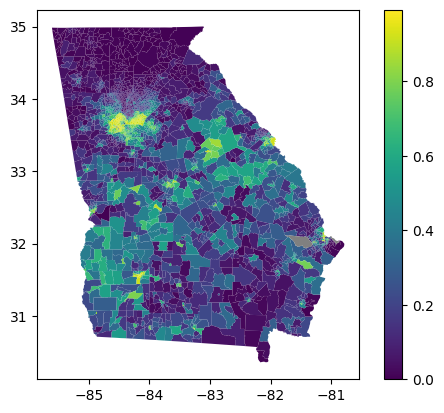

In [29]:
# Plot the black population percentage by precincts
check_gdf['b_frac'] = pd.to_numeric(check_gdf['POPBAA'])/pd.to_numeric(check_gdf['TOTPOP'])
check_gdf.plot(column = 'b_frac', missing_kwds = {"color":"grey"}, legend=True)

<Axes: >

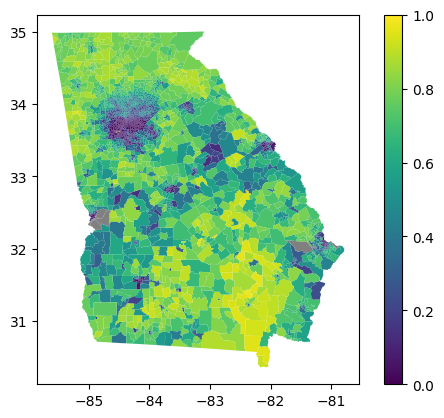

In [30]:
# Plot the senate republican votes by precincts
check_gdf['senate_r_perc'] = pd.to_numeric(check_gdf['G22USSRWAL'])/pd.to_numeric(check_gdf["G22USSRWAL"] + check_gdf["G22USSDWAR"] + check_gdf["G22USSLOLI"])
check_gdf.plot(column = 'senate_r_perc', missing_kwds = {"color":"grey"}, legend=True)

Looks like it!

## Saving

In [34]:
# Save data to a shapefile so we don't have to join all the data again
ga_data_gdf.to_file("./save-new-data/GA-election-census-data-by-precincts.shp")